<a href="https://colab.research.google.com/github/beverly0005/ppg_project/blob/main/Nature_ResNet34_bw_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Modify based on Toy_ResNet34_v1, but with the following updates:
1. Change Model Architecture according to the Nature paper in "Build All"
2. Refer to "ResNet34.ipynb" to modify:
    + Add plot learning curves

# Import Libraries

In [ ]:
!nvidia-smi

Tue Dec 16 08:53:27 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   75C    P0             33W /   70W |     292MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
!pip install mlflow

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import time
from datetime import datetime
from google.colab import drive
import mlflow
import mlflow.pytorch

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# User-Defined Parameters

In [ ]:
# File path and files
DATAPATH = 'drive/MyDrive/2025_PPG_GLUC/Data/Model Data/Model Data_NewProc_bw_v2/'
MODELPATH = 'drive/MyDrive/2025_PPG_GLUC/Models/Nature_Resnet34_NewProcData_bw_v2/'

if not os.path.exists(MODELPATH):
    os.makedirs(MODELPATH)

# Configure MLflow to save to your Google Drive
mlflow.set_tracking_uri(f"file:/content/drive/MyDrive/2025_PPG_GLUC/mlruns")

# Model hyperparameters
BATCH_SIZE = 128
EPOCHS = 5
LEARNING_RATE = 1e-2
WEIGHT_DECAY = 1e-4
SEED = 42

# Self-Defined Functions

In [ ]:
def plot_learning_curve_by_data_size(model_class, X_train, y_train, X_val, y_val, X_test, y_test):
    """Plot performance vs training data size"""

    # Different training data sizes: 10%, 25%, 50%, 75%, 100%
    train_sizes = [0.1, 0.25, 0.5, 0.75, 1.0]

    results = {
        'train_size': [],
        'train_loss': [],
        'val_loss': [],
        'test_loss': [],
        'train_mae': [],
        'val_mae': [],
        'test_mae': []
    }

    for size in train_sizes:
        # Sample data
        n_samples = int(len(X_train) * size)
        indices = np.random.choice(len(X_train), n_samples, replace=False)
        X_train_sub = X_train[indices]
        y_train_sub = y_train[indices]

        # Train model
        model = model_class()
        # ... train with X_train_sub, y_train_sub

        # Evaluate
        train_metrics = evaluate(model, X_train_sub, y_train_sub)
        val_metrics = evaluate(model, X_val, y_val)
        test_metrics = evaluate(model, X_test, y_test)

        results['train_size'].append(n_samples)
        results['train_loss'].append(train_metrics['loss'])
        results['val_loss'].append(val_metrics['loss'])
        results['test_loss'].append(test_metrics['loss'])
        # ... store MAE

    # Plot
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(results['train_size'], results['train_loss'], 'o-', label='Train')
    plt.plot(results['train_size'], results['val_loss'], 's-', label='Val')
    plt.plot(results['train_size'], results['test_loss'], '^-', label='Test')
    plt.xlabel('Training Samples')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss vs Training Data Size')

    plt.subplot(1, 2, 2)
    plt.plot(results['train_size'], results['train_mae'], 'o-', label='Train')
    plt.plot(results['train_size'], results['val_mae'], 's-', label='Val')
    plt.plot(results['train_size'], results['test_mae'], '^-', label='Test')
    plt.xlabel('Training Samples')
    plt.ylabel('MAE (mg/dL)')
    plt.legend()
    plt.title('MAE vs Training Data Size')

    plt.tight_layout()
    plt.show()

    return results

# Load and Process Data

In [ ]:
def load_and_preprocess_data(data_dir, standardize=True):
    """
    Load and preprocess PPG data with Per-Sample Scaling.
    """
    print(f"Loading data from {data_dir}...")

    try:
        # Load numpy arrays
        X_train = np.load(os.path.join(data_dir, 'X_train.npy'))
        y_train = np.load(os.path.join(data_dir, 'y_train.npy'))
        X_val = np.load(os.path.join(data_dir, 'X_val.npy'))
        y_val = np.load(os.path.join(data_dir, 'y_val.npy'))

        # Load Test if available
        if os.path.exists(os.path.join(data_dir, 'X_test.npy')):
            X_test = np.load(os.path.join(data_dir, 'X_test.npy'))
            y_test = np.load(os.path.join(data_dir, 'y_test.npy'))
            metadata_test = pd.read_csv(os.path.join(data_dir, 'metadata_test.csv'))
        else:
            X_test, y_test, metadata_test = None, None, None

        # Reshape for 1D CNN: (N, Channels, Time) -> (N, 1, 120)
        # Note: Input is usually (N, 120)
        X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
        X_val = X_val.reshape(X_val.shape[0], X_val.shape[1])
        if X_test is not None:
             X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])

        if standardize:
            print("Standardizing PPG data (Per-Sample Scaling)...")

            # Helper to scale each signal to 0-1 independently
            def scale_per_sample(data):
                # data shape: (N, 120)
                min_vals = data.min(axis=1, keepdims=True)
                max_vals = data.max(axis=1, keepdims=True)
                range_vals = max_vals - min_vals

                # Avoid division by zero
                range_vals[range_vals == 0] = 1e-8

                return (data - min_vals) / range_vals

            X_train = scale_per_sample(X_train)
            X_val = scale_per_sample(X_val)
            if X_test is not None:
                X_test = scale_per_sample(X_test)

            print(f"  Scaling Done. Train Mean: {X_train.mean():.4f}")

        # Convert to PyTorch Tensors and add Channel Dimension (N, 1, 120)
        data_dict = {
            'X_train': torch.FloatTensor(X_train).unsqueeze(1),
            'y_train': torch.FloatTensor(y_train),
            'X_val': torch.FloatTensor(X_val).unsqueeze(1),
            'y_val': torch.FloatTensor(y_val)
        }

        if X_test is not None:
            data_dict['X_test'] = torch.FloatTensor(X_test).unsqueeze(1)
            data_dict['y_test'] = torch.FloatTensor(y_test)
            data_dict['metadata_test'] = metadata_test

        return data_dict

    except Exception as e:
        print(f"Error loading data: {e}")
        return None

# ResNet34
* Reference: https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py
* Build from scratch: https://www.analyticsvidhya.com/blog/2021/09/building-resnet-34-model-using-pytorch-a-guide-for-beginners/
* Any improvement from https://www.kaggle.com/code/poonaml/building-resnet34-from-scratch-using-pytorch

## Configuration

In [ ]:
# Set random seeds
np.random.seed(SEED)
torch.manual_seed(SEED)

# GPU setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_gpus = torch.cuda.device_count()
print(f"Using {num_gpus} GPUs")

Using 1 GPUs


## Residual Block

* Remove dropout layer
* Remove shortcut
* According to Nature Paper:
    * Remove batchnorm after 2nd 1-D CNN

In [ ]:
# ResidualBlock definition for 1D data
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.stride = stride
        self.in_channels = in_channels
        self.out_channels = out_channels

        # First convolution
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3,
                              stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        # self.dropout = nn.Dropout(0.3)  # Remove dropout

        # Second convolution
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3,
                              stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)

        # Shortcut connection (identity or projection)
        # self.shortcut = nn.Sequential()
        if self.stride != 1 or self.in_channels != self.out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv1d(self.in_channels, self.out_channels, kernel_size=1,
                         stride=self.stride, bias=False),
                nn.BatchNorm1d(out_channels)
            )

    def forward(self, x):
        identity = x

        # First conv block
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        # Second conv block
        out = self.conv2(out)
        # out = self.bn2(out)

        # Skip connection
        # out += self.shortcut(identity)
        if self.stride != 1 or self.in_channels != self.out_channels:
            identity = self.shortcut(x)

        out += identity
        out = self.relu(out)

        return out

## Build All
1. Remove "num_classes": not necessary parameter
2. Initial conv1d:
    * kernal size changed to 7 (original 3)
    * Stride changed to 2 (original 1)
    * Add Max pool to Initial Conv
3. Dense layer:
    * Only 1 layer: (512, 1)
4. Modify initialization:
    * Initialize conv and batchnorm
    * Add zero_init_residual
    * Remove _initialize_fc_layers
5. According to Nature Paper:
    * Block 1: Remove MaxPool1d, Change Conv1d
    * Dense layers: modify to 2 layers (512, 256) and with relu
    * Remove zero_init_residual since there is no batchnorm for 2nd conv1d in the residual block

In [ ]:
class ResNet34(nn.Module):
    def __init__(self, in_channels=1, zero_init_residual=False):
        super().__init__()

        # Block 1: Initial Conv
        self.block1 = nn.Sequential(
            # nn.Conv1d(in_channels, 64, kernel_size=7, stride=2, padding=3,
            #           bias=False),
            nn.Conv1d(in_channels, 64, kernel_size=3, stride=1, padding='same',
                      bias=False),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            # nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        )

        # Block 2: First Residual Block Group
        self.block2 = nn.Sequential(
            ResidualBlock(64, 64),
            ResidualBlock(64, 64),
            ResidualBlock(64, 64)
        )

        # Block 3: Second Residual Block Group
        self.block3 = nn.Sequential(
            ResidualBlock(64, 128, stride=2),
            ResidualBlock(128, 128),
            ResidualBlock(128, 128),
            ResidualBlock(128, 128)
        )

        # Block 4: Third Residual Block Group
        self.block4 = nn.Sequential(
            ResidualBlock(128, 256, stride=2),
            ResidualBlock(256, 256),
            ResidualBlock(256, 256),
            ResidualBlock(256, 256),
            ResidualBlock(256, 256),
            ResidualBlock(256, 256)
        )

        # Block 5: Fourth Residual Block Group
        self.block5 = nn.Sequential(
            ResidualBlock(256, 512, stride=2),
            ResidualBlock(512, 512),
            ResidualBlock(512, 512)
        )

        # Global Average Pooling and Flatten
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.flatten = nn.Flatten()

        # Dense layers will be initialized in forward pass
        self.fc_initialized = False
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.fc1 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 1)

        # Initialization
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        #  # Zero-initialize the last BN in each residual branch,
        # # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        # if zero_init_residual:
        #     for m in self.modules():
        #         if isinstance(m, ResidualBlock) and m.bn2.weight is not None:
        #             nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]


    # def _initialize_fc_layers(self, x):
    #     """Dynamically initialize fully connected layers based on input shape"""
    #     # Get shape after processing through the network
    #     with torch.no_grad():
    #         # Forward through convolutional blocks
    #         x = self.block1(x)
    #         x = self.block2(x)
    #         x = self.block3(x)
    #         x = self.block4(x)
    #         x = self.block5(x)

    #         # Apply global pooling and flatten
    #         x = self.avgpool(x)
    #         x = self.flatten(x)

    #         # Get the flattened dimension
    #         fc_input_dim = x.shape[1]

    #         # Initialize dense layers with correct dimensions
    #         self.fc1 = nn.Linear(fc_input_dim, 256).to(x.device)
    #         self.fc2 = nn.Linear(256, 128).to(x.device)
    #         self.fc3 = nn.Linear(128, 1).to(x.device)

    #         print(f"Initialized FC layers with input dim: {fc_input_dim}")
    #         self.fc_initialized = True

    def forward(self, x):
        # # Initialize FC layers if not done already
        # if not self.fc_initialized:
        #     self._initialize_fc_layers(x)

        # Forward through blocks
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)

        # Global pooling and flatten
        # print(x.shape)
        x = self.avgpool(x)
        # print(x.shape)
        x = self.flatten(x)

        # Dense layers
        # x = self.relu1(self.fc1(x))
        # x = self.relu2(self.fc2(x))
        # x = self.fc3(x)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)

        return x.squeeze()

# Training

## Early Stopping

Modify by:
* Introducing mode ['min', 'max']: the smaller the better, or the bigger the better
* Remove score = -val_metric
* Update __call__

In [ ]:
# Early stopping implementation
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt',
                 monitor='val_mae', mode='min'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_min = float('inf')
        self.delta = delta
        self.path = path
        self.monitor = monitor
        self.mode = mode

        if self.mode == 'min':
            self.compare = lambda x, y: x < y - self.delta
        else:  # self.mode == 'max':
            self.compare = lambda x, y: x > y + self.delta


    def __call__(self, val_metric, model):
        # score = -val_metric  # Lower is better
        score = val_metric

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_metric, model)
        elif self.compare(score, self.best_score):
            self.best_score = score
            self.save_checkpoint(val_metric, model)
            self.counter = 0
        else:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True

        return self.early_stop

    def save_checkpoint(self, val_metric, model):
        if self.verbose:
            metric_name = "MAE" if self.monitor == 'val_mae' else "loss"
            print(f'Validation {metric_name} decreased ({self.val_min:.6f} --> {val_metric:.6f}). Saving model...')
        torch.save(model.state_dict(), self.path)
        self.val_min = val_metric


## Train An Epoch

Modify by:
* Add batch in the loop
* Remove torch.nn.utils.clip_grad_norm_

In [ ]:
# Training and evaluation functions (same as before)
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_mae = 0.0
    samples = 0

    # for inputs, targets in train_loader:
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # added gradient clipping
        optimizer.step()

        # Calculate metrics
        running_loss += loss.item() * inputs.size(0)
        running_mae += torch.sum(torch.abs(outputs - targets)).item()
        samples += inputs.size(0)

    epoch_loss = running_loss / samples
    epoch_mae = running_mae / samples

    return epoch_loss, epoch_mae


## Validate Model

Modify by:
* Add batch in the loop

In [ ]:
def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_mae = 0.0
    samples = 0

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            running_loss += loss.item() * inputs.size(0)
            running_mae += torch.sum(torch.abs(outputs - targets)).item()
            samples += inputs.size(0)

    val_loss = running_loss / samples
    val_mae = running_mae / samples

    return val_loss, val_mae


## Evaluate Model

In [ ]:
def evaluate_model(model, test_loader, device, output_dir, metadata_test):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)

            all_preds.extend(outputs.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    # Convert to numpy arrays
    y_pred = np.array(all_preds)
    y_test = np.array(all_targets)

    # Calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    # Calculate MARD (Mean Absolute Relative Difference %)
    mask = y_test != 0
    mard = np.mean(np.abs((y_test[mask] - y_pred[mask]) / y_test[mask])) * 100
    # Print metrics
    print("\nResNet34 Model Performance:")
    print(f"  RMSE: {rmse:.2f} mg/dL")
    print(f"  MAE: {mae:.2f} mg/dL")
    print(f"  MSE: {mse:.2f} (mg/dL)²")
    print(f"  MARD: {mard:.2f}%")
    print(f"  R²: {r2:.4f}")

    # Create results DataFrame
    results_df = pd.DataFrame({
        'metadata_id': metadata_test['metadata_id'].values,
        'true_glucose': y_test,
        'predicted_glucose': y_pred,
        'absolute_error': np.abs(y_test - y_pred),
        'relative_error_pct': np.abs((y_test[mask] - y_pred[mask]) / y_test[mask]) * 100 if len(mask) > 0 else np.zeros_like(y_test)
    })

    # Save results to CSV
    results_df.to_csv(os.path.join(output_dir, 'resnet34_test_predictions.csv'), index=False)

    # Save metrics to file
    with open(os.path.join(output_dir, 'metrics.txt'), 'w') as f:
        f.write(f"rmse: {rmse:.4f} mg/dL\n")
        f.write(f"mae: {mae:.4f} mg/dL\n")
        f.write(f"mse: {mse:.4f} (mg/dL)²\n")
        f.write(f"mard: {mard:.4f}%\n")
        f.write(f"r2: {r2:.4f}\n")

    # Create prediction scatter plot
    plt.figure(figsize=(10, 8))
    plt.scatter(y_test, y_pred, alpha=0.3, s=10)

    # Add perfect prediction line
    min_val = min(np.min(y_test), np.min(y_pred))
    max_val = max(np.max(y_test), np.max(y_pred))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')

    # Add stats text
    stats_text = (f'RMSE: {rmse:.2f} mg/dL\n'
                 f'MAE: {mae:.2f} mg/dL\n'
                 f'MSE: {mse:.2f} (mg/dL)²\n'
                 f'MARD: {mard:.2f}%\n'
                 f'R²: {r2:.4f}')

    plt.text(0.05, 0.95, stats_text, transform=plt.gca().transAxes, fontsize=12,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.xlabel('True Glucose (mg/dL)', fontsize=12)
    plt.ylabel('Predicted Glucose (mg/dL)', fontsize=12)
    plt.title('ResNet34: True vs. Predicted Glucose Values', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'resnet34_predictions.png'), dpi=300)
    plt.show()

    return {
        'rmse': rmse,
        'mae': mae,
        'mse': mse,
        'mard': mard,
        'r2': r2
    }

## Logging

In [ ]:
# Log training metrics function (same as before)
def log_training_metrics(history, output_file):
    """Log best and final training metrics."""
    best_val_loss = min(history['val_loss'])
    best_val_idx = history['val_loss'].index(best_val_loss)

    best_val_mae = min(history['val_mae'])
    best_val_mae_idx = history['val_mae'].index(best_val_mae)

    # Calculate metrics at best MAE epoch
    best_mae_epoch = best_val_mae_idx + 1
    train_loss_at_best_mae = history['train_loss'][best_val_mae_idx]
    val_loss_at_best_mae = history['val_loss'][best_val_mae_idx]
    train_mae_at_best_mae = history['train_mae'][best_val_mae_idx]
    val_train_ratio_at_best_mae = val_loss_at_best_mae / train_loss_at_best_mae if train_loss_at_best_mae > 0 else float('inf')

    # Final epoch metrics
    final_train_loss = history['train_loss'][-1]
    final_val_loss = history['val_loss'][-1]
    final_train_mae = history['train_mae'][-1]
    final_val_mae = history['val_mae'][-1]

    with open(output_file, 'w') as f:
        f.write("TRAINING METRICS SUMMARY\n")
        f.write("=======================\n\n")
        f.write(f"Total training epochs: {len(history['train_loss'])}\n\n")

        f.write("BEST VALIDATION MAE EPOCH (Primary Metric)\n")
        f.write(f"Best validation MAE: {best_val_mae:.4f} mg/dL at epoch {best_mae_epoch}\n")
        f.write(f"  Training MAE at this epoch: {train_mae_at_best_mae:.4f} mg/dL\n")
        f.write(f"  Validation loss at this epoch: {val_loss_at_best_mae:.4f}\n")
        f.write(f"  Training loss at this epoch: {train_loss_at_best_mae:.4f}\n")
        f.write(f"  Val/Train loss ratio at this epoch: {val_train_ratio_at_best_mae:.4f}\n\n")

        f.write("BEST VALIDATION LOSS EPOCH\n")
        f.write(f"Best validation loss: {best_val_loss:.4f} at epoch {best_val_idx + 1}\n\n")

        f.write("FINAL EPOCH METRICS\n")
        f.write(f"Final validation loss: {final_val_loss:.4f}\n")
        f.write(f"Final training loss: {final_train_loss:.4f}\n")
        f.write(f"Final validation MAE: {final_val_mae:.4f} mg/dL\n")
        f.write(f"Final training MAE: {final_train_mae:.4f} mg/dL\n")

    # Return metrics dictionary
    return {
        'best_val_mae': best_val_mae,
        'best_val_mae_epoch': best_mae_epoch,
        'train_mae_at_best_mae': train_mae_at_best_mae,
        'val_loss_at_best_mae': val_loss_at_best_mae,
        'train_loss_at_best_mae': train_loss_at_best_mae,
        'val_train_ratio_at_best_mae': val_train_ratio_at_best_mae,
        'best_val_loss': best_val_loss,
        'best_val_loss_epoch': best_val_idx + 1,
    }

In [ ]:
# Add this function to your code
def log_to_mlflow(model_name, model, history, test_metrics, output_dir):
    """Log existing model results to MLflow."""

    # Set up MLflow
    experiment_name = "PPG_Glucose_Prediction"
    mlflow.set_experiment(experiment_name)

    # Find best values
    best_val_mae = min(history['val_mae'])
    best_val_mae_idx = history['val_mae'].index(best_val_mae)
    best_val_loss = min(history['val_loss'])

    # Start MLflow run
    with mlflow.start_run(run_name=f"{model_name}_Attempt4"):
        # 1. Log hyperparameters
        mlflow.log_params({
            "model_type": model_name,
            "batch_size": BATCH_SIZE,
            "learning_rate": LEARNING_RATE,
            "epochs_trained": len(history['train_loss']),
            "early_stopping_patience": 7
        })

        # Add model-specific params
        if model_name == "ResNet34":
            mlflow.log_param("weight_decay", WEIGHT_DECAY)
        elif model_name == "InceptionTime":
            mlflow.log_params({
                "n_blocks": 2,
                "n_filters": 32,
                "kernel_sizes": "[9,19,39]"
            })
        elif model_name == "BiLSTM":
            mlflow.log_params({
                "lstm_units": 64,
                "dropout_rate": 0.2,
                "bidirectional": True
            })

        # 2. Log metrics
        # Best validation metrics
        mlflow.log_metrics({
            "best_val_mae": best_val_mae,
            "best_val_mae_epoch": best_val_mae_idx + 1,
            "best_val_loss": best_val_loss,

            # Test metrics
            "test_rmse": test_metrics['rmse'],
            "test_mae": test_metrics['mae'],
            "test_mse": test_metrics['mse'],
            "test_mard": test_metrics['mard'],
            "test_r2": test_metrics['r2']
        })

        # 3. Log epoch metrics
        for epoch, (train_loss, val_loss, train_mae, val_mae) in enumerate(zip(
                history['train_loss'], history['val_loss'],
                history['train_mae'], history['val_mae']), 1):
            mlflow.log_metrics({
                "train_loss": train_loss,
                "val_loss": val_loss,
                "train_mae": train_mae,
                "val_mae": val_mae
            }, step=epoch)

        # 4. Log the model
        mlflow.pytorch.log_model(model, "model")

        # 5. Log artifacts
        for file in os.listdir(output_dir):
            if file.endswith(('.png', '.csv', '.txt')):
                mlflow.log_artifact(os.path.join(output_dir, file))

## Train All

Loading data from drive/MyDrive/2025_PPG_GLUC/Data/Model Data/Model Data_NewProc_bw_v2/...
Standardizing PPG data (Per-Sample Scaling)...
  Scaling Done. Train Mean: 0.2263
ResNet34(
  (block1): Sequential(
    (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=same, bias=False)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (block2): Sequential(
    (0): ResidualBlock(
      (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
    )
    (1): ResidualBlock(
      (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 

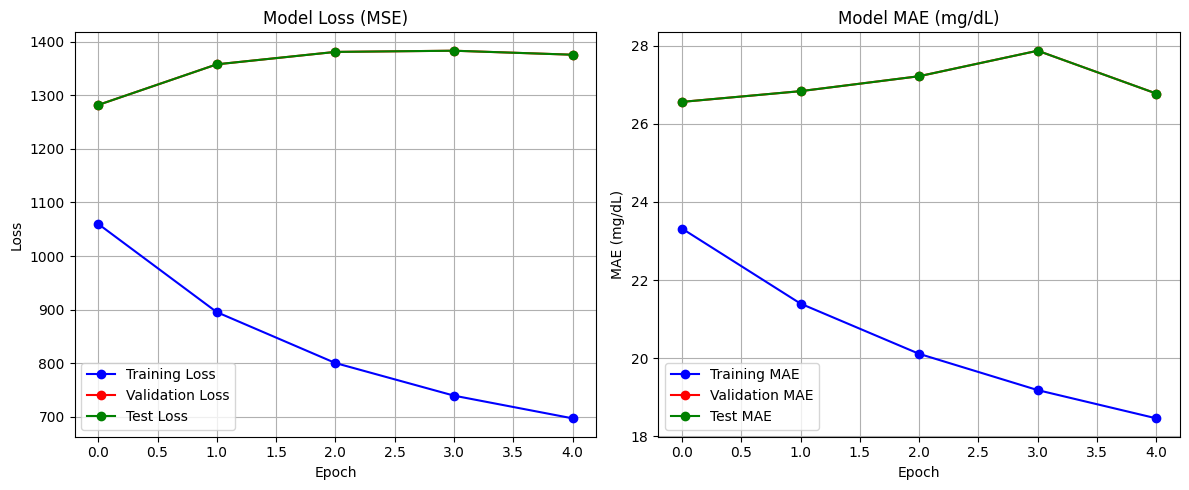


ResNet34 Model Performance:
  RMSE: 37.15 mg/dL
  MAE: 25.23 mg/dL
  MSE: 1379.86 (mg/dL)²
  MARD: 22.65%
  R²: 0.0200


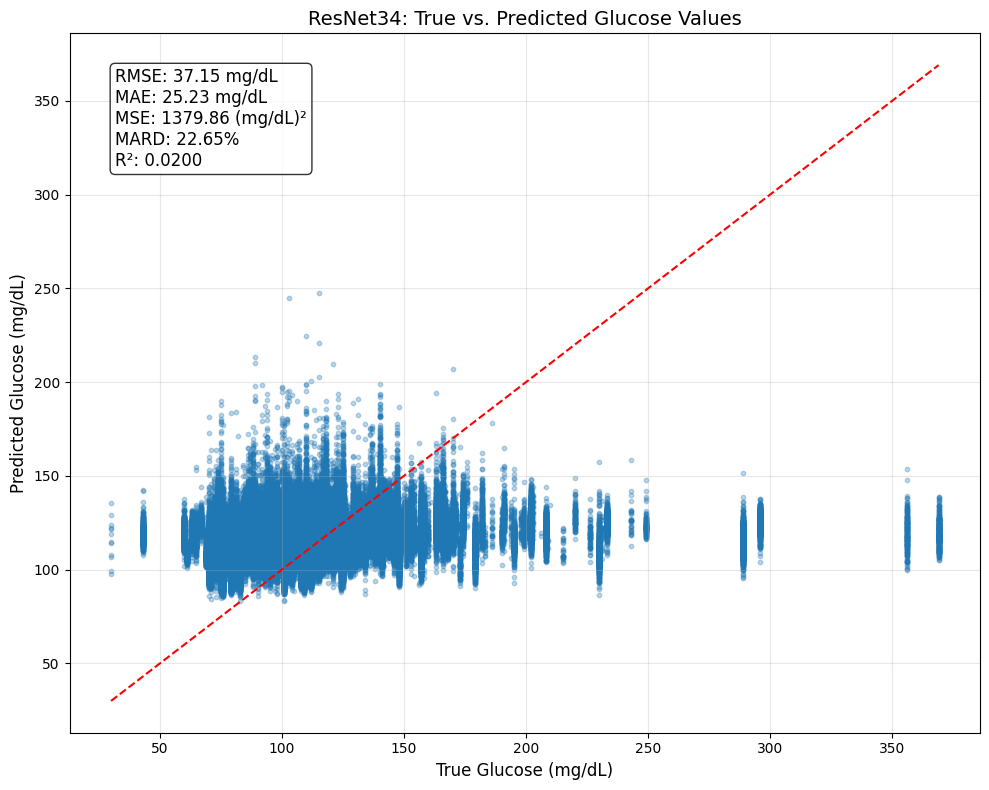


Best validation MAE: 26.5602 mg/dL at epoch 1
Final test metrics: RMSE=37.15 mg/dL, MAE=25.23 mg/dL
All results saved to: drive/MyDrive/2025_PPG_GLUC/Models/Nature_Resnet34_NewProcData_bw_v2/


/usr/local/lib/python3.12/dist-packages/mlflow/tracking/_tracking_service/utils.py:177: FutureWarning: The filesystem tracking backend (e.g., './mlruns') will be deprecated in February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See https://github.com/mlflow/mlflow/issues/18534 for more details and migration guidance.
  return FileStore(store_uri, store_uri)
2025/12/16 09:45:14 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/16 09:45:15 WARNING mlflow.utils.requirements_utils: Found torch version (2.9.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/12/16 09:45:24 WARNING mlflow.utils.requirements_utils: Found tor

In [ ]:
# Main execution
def main():
    # Load and preprocess data
    data = load_and_preprocess_data(DATAPATH, standardize=True)
    if data is None:
        print("Failed to load data. Exiting.")
        return

    # Create data loaders
    train_dataset = TensorDataset(data['X_train'], data['y_train'])
    val_dataset = TensorDataset(data['X_val'], data['y_val'])
    test_dataset = TensorDataset(data['X_test'], data['y_test'])

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Create ResNet34 model
    model = ResNet34(in_channels=1).to(device)
    print(model)

    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")

    # Define loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

    # Set up early stopping with MAE as monitor
    checkpoint_path = os.path.join(MODELPATH, 'best_model.pt')
    early_stopping = EarlyStopping(patience=50, verbose=True, path=checkpoint_path,
                                   monitor='val_mae', mode='min')

    # Initialize history tracking
    history = {
        'train_loss': [],
        'val_loss': [],
        'test_loss': [],
        'train_mae': [],
        'val_mae': [],
        'test_mae': []
    }

    # Train the model
    print(f"\nTraining ResNet34 for {EPOCHS} epochs...")
    start_time = time.time()

    for epoch in range(EPOCHS):
        epoch_start = time.time()

        # Train and validate for one epoch
        train_loss, train_mae = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_mae = validate(model, val_loader, criterion, device)
        test_loss, test_mae = validate(model, val_loader, criterion, device)

        # Record history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['test_loss'].append(test_loss)
        history['train_mae'].append(train_mae)
        history['val_mae'].append(val_mae)
        history['test_mae'].append(test_mae)

        # Save history to CSV after each epoch
        history_df = pd.DataFrame({
            'epoch': list(range(1, len(history['train_loss']) + 1)),
            'train_loss': history['train_loss'],
            'val_loss': history['val_loss'],
            'test_loss': history['test_loss'],
            'train_mae': history['train_mae'],
            'val_mae': history['val_mae'],
            'test_mae': history['test_mae'],
            'val_train_ratio': [v/t if t > 0 else float('inf') for v, t in zip(history['val_loss'], history['train_loss'])]
        })
        history_df.to_csv(os.path.join(MODELPATH, 'training_history.csv'), index=False)

        # Print epoch stats
        epoch_time = time.time() - epoch_start
        print(f"Epoch {epoch+1}/{EPOCHS} - {epoch_time:.1f}s - "
              f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f},  Test Loss: {test_loss:.4f}"
              f"Train MAE: {train_mae:.2f}, Val MAE: {val_mae:.2f}, Test Loss: {test_loss:.4f}"
              f"Ratio: {val_loss/train_loss:.4f}")

        # Check early stopping
        if early_stopping(val_mae, model):
            print("Early stopping triggered!")
            break

    total_time = time.time() - start_time
    print(f"Training completed in {total_time:.2f} seconds")

    # Plot loss curves
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], 'b-o', label='Training Loss')
    plt.plot(history['val_loss'], 'r-o', label='Validation Loss')
    plt.plot(history['test_loss'], 'g-o', label='Test Loss')
    plt.title('Model Loss (MSE)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history['train_mae'], 'b-o', label='Training MAE')
    plt.plot(history['val_mae'], 'r-o', label='Validation MAE')
    plt.plot(history['test_mae'], 'g-o', label='Test MAE')
    plt.title('Model MAE (mg/dL)')
    plt.xlabel('Epoch')
    plt.ylabel('MAE (mg/dL)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(os.path.join(MODELPATH, 'training_curves.png'), dpi=300)
    plt.show()

    # Log detailed training metrics
    metrics_summary = log_training_metrics(
        history,
        os.path.join(MODELPATH, 'training_metrics_summary.txt')
    )

    # Load the best model
    model.load_state_dict(torch.load(checkpoint_path))

    # Evaluate model on test set
    test_metrics = evaluate_model(
        model,
        test_loader,
        device,
        MODELPATH,
        data['metadata_test']
    )

    print(f"\nBest validation MAE: {metrics_summary['best_val_mae']:.4f} mg/dL at epoch {metrics_summary['best_val_mae_epoch']}")
    print(f"Final test metrics: RMSE={test_metrics['rmse']:.2f} mg/dL, MAE={test_metrics['mae']:.2f} mg/dL")
    print(f"All results saved to: {MODELPATH}")

    log_to_mlflow("ResNet34", model, history, test_metrics, MODELPATH)

if __name__ == "__main__":
    main()

# Clarke Error Grid

Modified based on https://github.com/kriventsov/Clarke-and-Parkes-Error-Grids/blob/master/error_grids.py:

* Modify Zone D: if act <= 70 <= pred <= 180

In [ ]:
"""
Implementation of Clarke and Parkes error grid analysis
"""


def clarke_error_zone_detailed(act, pred):
    """
    This function outputs the Clarke Error Grid region (encoded as integer)
    for a combination of actual and predicted value

    Based on 'Evaluating clinical accuracy of systems for self-monitoring of blood glucose':
    https://care.diabetesjournals.org/content/10/5/622
    """
    # Zone A
    if (act < 70 and pred < 70) or abs(act - pred) < 0.2 * act:
        return 0
    # Zone E - left upper
    if act <= 70 and pred >= 180:
        return 8
    # Zone E - right lower
    if act >= 180 and pred <= 70:
        return 7
    # Zone D - right
    if act >= 240 and 70 <= pred <= 180:
        return 6
    # Zone D - left
    # if act <= 70 <= pred <= 180:
    if act < 58 and 70<= pred <= 180:
        return 5
    # Zone D - left
    if 58<= act <= 70 and pred >= act * 1.2:
        return 5
    # Zone C - upper
    if 70 <= act <= 290 and pred >= act + 110:
        return 4
    # Zone C - lower
    if 130 <= act <= 180 and pred <= (7/5) * act - 182:
        return 3
    # Zone B - upper
    if act < pred:
        return 2
    # Zone B - lower
    return 1

def parkes_error_zone_detailed(act, pred, diabetes_type):
    """
    This function outputs the Parkes Error Grid region (encoded as integer)
    for a combination of actual and predicted value
    for type 1 and type 2 diabetic patients

    Based on the article 'Technical Aspects of the Parkes Error Grid':
    https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3876371/
    """
    def above_line(x_1, y_1, x_2, y_2, strict=False):
        if x_1 == x_2:
            return False

        y_line = ((y_1 - y_2) * act + y_2 * x_1 - y_1 * x_2) / (x_1 - x_2)
        return pred > y_line if strict else pred >= y_line

    def below_line(x_1, y_1, x_2, y_2, strict=False):
        return not above_line(x_1, y_1, x_2, y_2, not strict)

    def parkes_type_1(act, pred):
        # Zone E
        if above_line(0, 150, 35, 155) and above_line(35, 155, 50, 550):
            return 7
        # Zone D - left upper
        if (pred > 100 and above_line(25, 100, 50, 125) and
                above_line(50, 125, 80, 215) and above_line(80, 215, 125, 550)):
            return 6
        # Zone D - right lower
        if (act > 250 and below_line(250, 40, 550, 150)):
            return 5
        # Zone C - left upper
        if (pred > 60 and above_line(30, 60, 50, 80) and
                above_line(50, 80, 70, 110) and above_line(70, 110, 260, 550)):
            return 4
        # Zone C - right lower
        if (act > 120 and below_line(120, 30, 260, 130) and below_line(260, 130, 550, 250)):
            return 3
        # Zone B - left upper
        if (pred > 50 and above_line(30, 50, 140, 170) and
                above_line(140, 170, 280, 380) and (act < 280 or above_line(280, 380, 430, 550))):
            return 2
        # Zone B - right lower
        if (act > 50 and below_line(50, 30, 170, 145) and
                below_line(170, 145, 385, 300) and (act < 385 or below_line(385, 300, 550, 450))):
            return 1
        # Zone A
        return 0

    def parkes_type_2(act, pred):
        # Zone E
        if (pred > 200 and above_line(35, 200, 50, 550)):
            return 7
        # Zone D - left upper
        if (pred > 80 and above_line(25, 80, 35, 90) and above_line(35, 90, 125, 550)):
            return 6
        # Zone D - right lower
        if (act > 250 and below_line(250, 40, 410, 110) and below_line(410, 110, 550, 160)):
            return 5
        # Zone C - left upper
        if (pred > 60 and above_line(30, 60, 280, 550)):
            return 4
        # Zone C - right lower
        if (below_line(90, 0, 260, 130) and below_line(260, 130, 550, 250)):
            return 3
        # Zone B - left upper
        if (pred > 50 and above_line(30, 50, 230, 330) and
                (act < 230 or above_line(230, 330, 440, 550))):
            return 2
        # Zone B - right lower
        if (act > 50 and below_line(50, 30, 90, 80) and below_line(90, 80, 330, 230) and
                (act < 330 or below_line(330, 230, 550, 450))):
            return 1
        # Zone A
        return 0

    if diabetes_type == 1:
        return parkes_type_1(act, pred)

    if diabetes_type == 2:
        return parkes_type_2(act, pred)

    raise Exception('Unsupported diabetes type')

clarke_error_zone_detailed = np.vectorize(clarke_error_zone_detailed)
parkes_error_zone_detailed = np.vectorize(parkes_error_zone_detailed)

def zone_accuracy(act_arr, pred_arr, mode='clarke', detailed=False, diabetes_type=1):
    """
    Calculates the average percentage of each zone based on Clarke or Parkes
    Error Grid analysis for an array of predictions and an array of actual values
    """
    acc = np.zeros(9)
    if mode == 'clarke':
        res = clarke_error_zone_detailed(act_arr, pred_arr)
    elif mode == 'parkes':
        res = parkes_error_zone_detailed(act_arr, pred_arr, diabetes_type)
    else:
        raise Exception('Unsupported error grid mode')

    acc_bin = np.bincount(res)
    acc[:len(acc_bin)] = acc_bin

    if not detailed:
        acc[1] = acc[1] + acc[2]
        acc[2] = acc[3] + acc[4]
        acc[3] = acc[5] + acc[6]
        acc[4] = acc[7] + acc[8]
        acc = acc[:5]

    return acc / sum(acc)

# End

In [ ]:
'''
CLARKE ERROR GRID ANALYSIS      ClarkeErrorGrid.py

Need Matplotlib Pyplot


The Clarke Error Grid shows the differences between a blood glucose predictive measurement and a reference measurement,
and it shows the clinical significance of the differences between these values.
The x-axis corresponds to the reference value and the y-axis corresponds to the prediction.
The diagonal line shows the prediction value is the exact same as the reference value.
This grid is split into five zones. Zone A is defined as clinical accuracy while
zones C, D, and E are considered clinical error.

Zone A: Clinically Accurate
    This zone holds the values that differ from the reference values no more than 20 percent
    or the values in the hypoglycemic range (<70 mg/dl).
    According to the literature, values in zone A are considered clinically accurate.
    These values would lead to clinically correct treatment decisions.

Zone B: Clinically Acceptable
    This zone holds values that differe more than 20 percent but would lead to
    benign or no treatment based on assumptions.

Zone C: Overcorrecting
    This zone leads to overcorrecting acceptable BG levels.

Zone D: Failure to Detect
    This zone leads to failure to detect and treat errors in BG levels.
    The actual BG levels are outside of the acceptable levels while the predictions
    lie within the acceptable range

Zone E: Erroneous treatment
    This zone leads to erroneous treatment because prediction values are opposite to
    actual BG levels, and treatment would be opposite to what is recommended.


SYNTAX:
        plot, zone = clarke_error_grid(ref_values, pred_values, title_string)

INPUT:
        ref_values          List of n reference values.
        pred_values         List of n prediciton values.
        title_string        String of the title.

OUTPUT:
        plot                The Clarke Error Grid Plot returned by the function.
                            Use this with plot.show()
        zone                List of values in each zone.
                            0=A, 1=B, 2=C, 3=D, 4=E

EXAMPLE:
        plot, zone = clarke_error_grid(ref_values, pred_values, "00897741 Linear Regression")
        plot.show()

References:
[1]     Clarke, WL. (2005). "The Original Clarke Error Grid Analysis (EGA)."
        Diabetes Technology and Therapeutics 7(5), pp. 776-779.
[2]     Maran, A. et al. (2002). "Continuous Subcutaneous Glucose Monitoring in Diabetic
        Patients" Diabetes Care, 25(2).
[3]     Kovatchev, B.P. et al. (2004). "Evaluating the Accuracy of Continuous Glucose-
        Monitoring Sensors" Diabetes Care, 27(8).
[4]     Guevara, E. and Gonzalez, F. J. (2008). Prediction of Glucose Concentration by
        Impedance Phase Measurements, in MEDICAL PHYSICS: Tenth Mexican
        Symposium on Medical Physics, Mexico City, Mexico, vol. 1032, pp.
        259261.
[5]     Guevara, E. and Gonzalez, F. J. (2010). Joint optical-electrical technique for
        noninvasive glucose monitoring, REVISTA MEXICANA DE FISICA, vol. 56,
        no. 5, pp. 430434.


Made by:
Trevor Tsue
7/18/17

Based on the Matlab Clarke Error Grid Analysis File Version 1.2 by:
Edgar Guevara Codina
codina@REMOVETHIScactus.iico.uaslp.mx
March 29 2013
'''



import matplotlib.pyplot as plt


#This function takes in the reference values and the prediction values as lists and returns a list with each index corresponding to the total number
#of points within that zone (0=A, 1=B, 2=C, 3=D, 4=E) and the plot
def clarke_error_grid(ref_values, pred_values, title_string):

    #Checking to see if the lengths of the reference and prediction arrays are the same
    assert (len(ref_values) == len(pred_values)), "Unequal number of values (reference : {}) (prediction : {}).".format(len(ref_values), len(pred_values))

#Checks to see if the values are within the normal physiological range, otherwise it gives a warning
    if max(ref_values) > 400 or max(pred_values) > 400:
        # FIXED: Added parentheses
        print("Input Warning: the maximum reference value {} or the maximum prediction value {} exceeds the normal physiological range of glucose (<400 mg/dl).".format(max(ref_values), max(pred_values)))

    if min(ref_values) < 0 or min(pred_values) < 0:
        # FIXED: Added parentheses here as well (this would be the next error)
        print("Input Warning: the minimum reference value {} or the minimum prediction value {} is less than 0 mg/dl.".format(min(ref_values),  min(pred_values)))
    #Clear plot
    plt.clf()

    #Set up plot
    plt.scatter(ref_values, pred_values, marker='o', color='black', s=8)
    plt.title(title_string + " Clarke Error Grid")
    plt.xlabel("Reference Concentration (mg/dl)")
    plt.ylabel("Prediction Concentration (mg/dl)")
    plt.xticks([0, 50, 100, 150, 200, 250, 300, 350, 400])
    plt.yticks([0, 50, 100, 150, 200, 250, 300, 350, 400])
    plt.gca().set_facecolor('white')

    #Set axes lengths
    plt.gca().set_xlim([0, 400])
    plt.gca().set_ylim([0, 400])
    plt.gca().set_aspect((400)/(400))

    #Plot zone lines
    plt.plot([0,400], [0,400], ':', c='black')                      #Theoretical 45 regression line
    plt.plot([0, 175/3], [70, 70], '-', c='black')
    #plt.plot([175/3, 320], [70, 400], '-', c='black')
    plt.plot([175/3, 400/1.2], [70, 400], '-', c='black')           #Replace 320 with 400/1.2 because 100*(400 - 400/1.2)/(400/1.2) =  20% error
    plt.plot([70, 70], [84, 400],'-', c='black')
    plt.plot([0, 70], [180, 180], '-', c='black')
    plt.plot([70, 290],[180, 400],'-', c='black')
    # plt.plot([70, 70], [0, 175/3], '-', c='black')
    plt.plot([70, 70], [0, 56], '-', c='black')                     #Replace 175.3 with 56 because 100*abs(56-70)/70) = 20% error
    # plt.plot([70, 400],[175/3, 320],'-', c='black')
    plt.plot([70, 400], [56, 320],'-', c='black')
    plt.plot([180, 180], [0, 70], '-', c='black')
    plt.plot([180, 400], [70, 70], '-', c='black')
    plt.plot([240, 240], [70, 180],'-', c='black')
    plt.plot([240, 400], [180, 180], '-', c='black')
    plt.plot([130, 180], [0, 70], '-', c='black')

    #Add zone titles
    plt.text(30, 15, "A", fontsize=15)
    plt.text(370, 260, "B", fontsize=15)
    plt.text(280, 370, "B", fontsize=15)
    plt.text(160, 370, "C", fontsize=15)
    plt.text(160, 15, "C", fontsize=15)
    plt.text(30, 140, "D", fontsize=15)
    plt.text(370, 120, "D", fontsize=15)
    plt.text(30, 370, "E", fontsize=15)
    plt.text(370, 15, "E", fontsize=15)

    #Statistics from the data
    zone = [0] * 5
    for i in range(len(ref_values)):
        if (ref_values[i] <= 70 and pred_values[i] <= 70) or (pred_values[i] <= 1.2*ref_values[i] and pred_values[i] >= 0.8*ref_values[i]):
            zone[0] += 1    #Zone A

        elif (ref_values[i] >= 180 and pred_values[i] <= 70) or (ref_values[i] <= 70 and pred_values[i] >= 180):
            zone[4] += 1    #Zone E

        elif ((ref_values[i] >= 70 and ref_values[i] <= 290) and pred_values[i] >= ref_values[i] + 110) or ((ref_values[i] >= 130 and ref_values[i] <= 180) and (pred_values[i] <= (7/5)*ref_values[i] - 182)):
            zone[2] += 1    #Zone C
        elif (ref_values[i] >= 240 and (pred_values[i] >= 70 and pred_values[i] <= 180)) or (ref_values[i] <= 175/3 and pred_values[i] <= 180 and pred_values[i] >= 70) or ((ref_values[i] >= 175/3 and ref_values[i] <= 70) and pred_values[i] >= (6/5)*ref_values[i]):
            zone[3] += 1    #Zone D
        else:
            zone[1] += 1    #Zone B

    return plt, zone

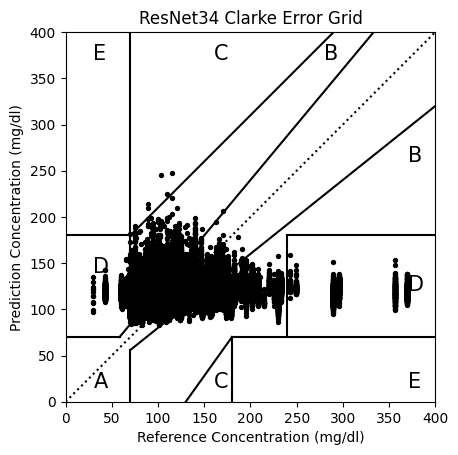

Zone A (Accurate): 95258
Zone B (Acceptable): 72937
Zone C (Overcorrecting): 7
Zone D (Failure to Detect): 6943
Zone E (Erroneous): 1


In [ ]:
# 1. Load the predictions saved by your model
results_path = os.path.join(MODELPATH, 'resnet34_test_predictions.csv')

if os.path.exists(results_path):
    results_df = pd.read_csv(results_path)

    # 2. Extract the True vs Predicted values
    ref_values = results_df['true_glucose'].values
    pred_values = results_df['predicted_glucose'].values

    # 3. Call the function (Capture the 'plot' object it returns)
    plot, zone = clarke_error_grid(ref_values, pred_values, "ResNet34")

    # 4. Show the plot
    plot.show()

    # Optional: Print the zone statistics
    print(f"Zone A (Accurate): {zone[0]}")
    print(f"Zone B (Acceptable): {zone[1]}")
    print(f"Zone C (Overcorrecting): {zone[2]}")
    print(f"Zone D (Failure to Detect): {zone[3]}")
    print(f"Zone E (Erroneous): {zone[4]}")

else:
    print(f"Could not find results file at {results_path}. Make sure you ran the evaluation step!")

Grad Cam visualization

Targeting Data Source: /content/drive/MyDrive/2025_PPG_GLUC/Data/Model Data/Model Data_NewProc_bw_v2/


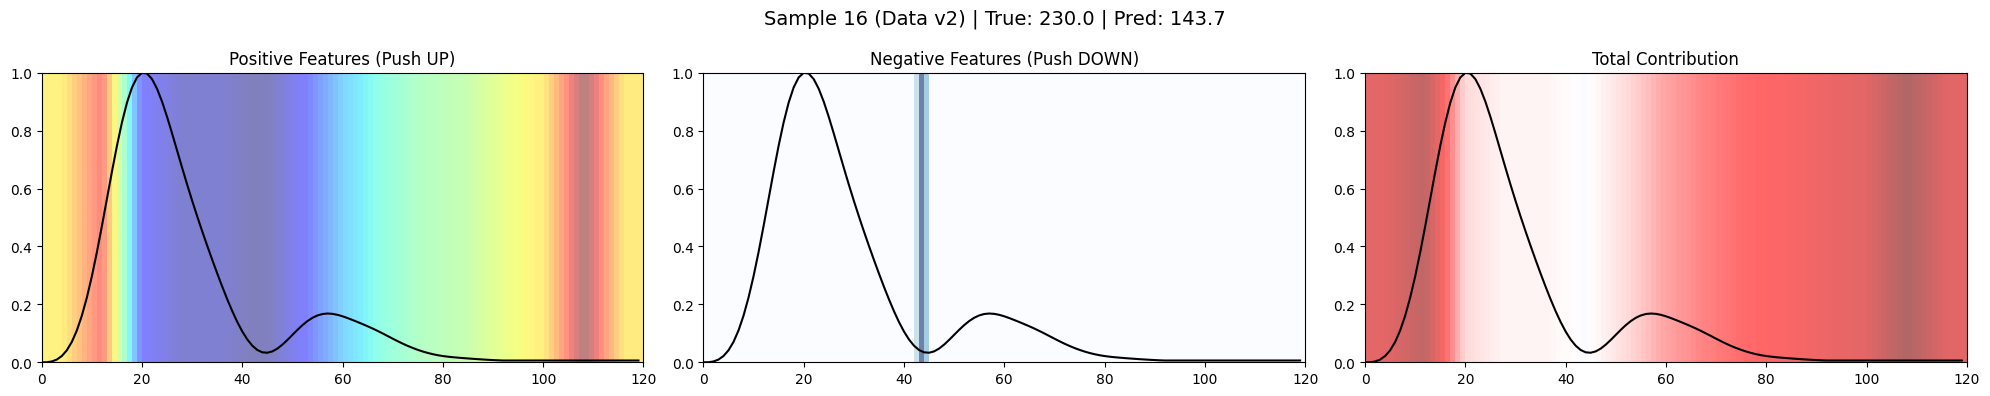

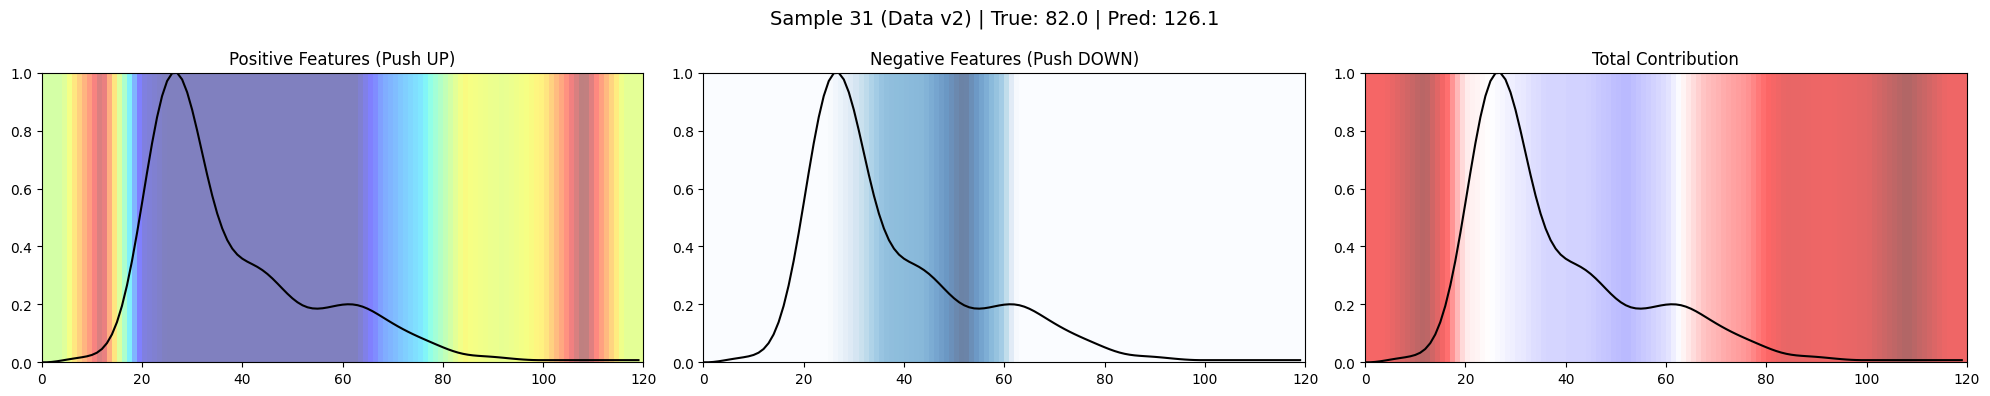

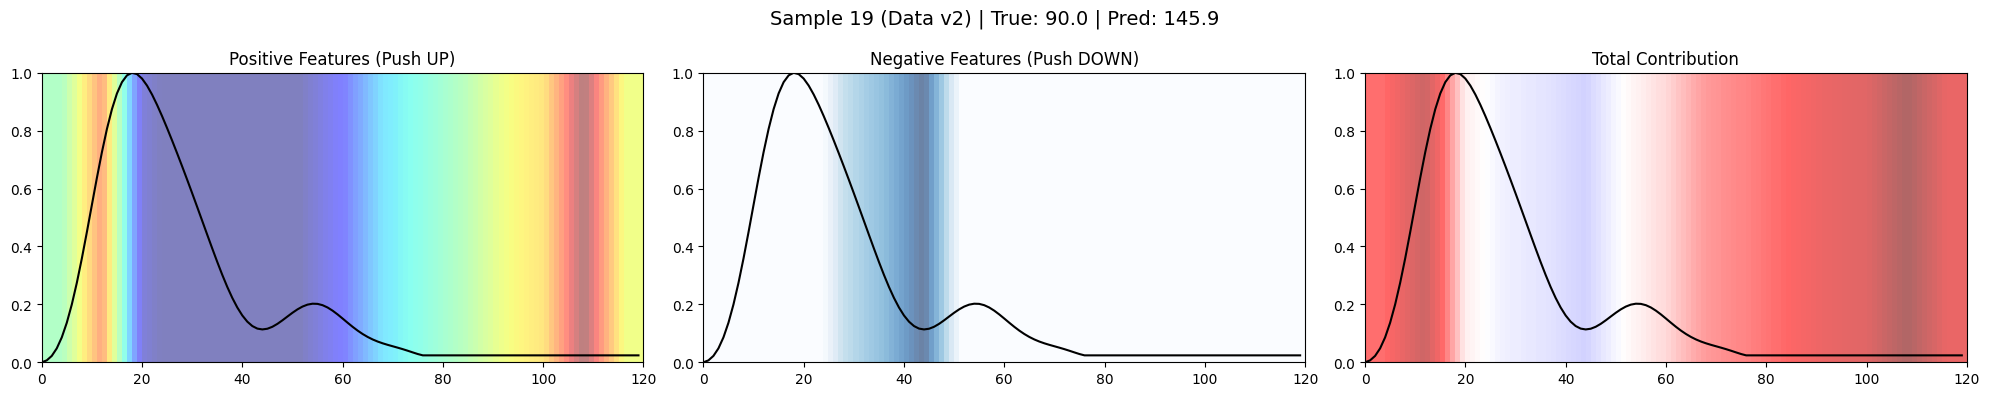

In [ ]:
# ==========================================
# FINAL GRAD-CAM VISUALIZATION BLOCK
# (Includes Data Loading for v2 to ensure correctness)
# ==========================================

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import os
from torch.utils.data import DataLoader, TensorDataset

# 1. SETUP PATH TO v2 DATA
# ------------------------------------------
# We explicitly define the v2 path here to avoid using old variables
DATA_V2_PATH = '/content/drive/MyDrive/2025_PPG_GLUC/Data/Model Data/Model Data_NewProc_bw_v2/'
print(f"Targeting Data Source: {DATA_V2_PATH}")

# 2. LOAD TEST DATA (v2)
# ------------------------------------------
def get_v2_test_loader(batch_size=32):
    try:
        # Load X_test and y_test
        X_test = np.load(os.path.join(DATA_V2_PATH, 'X_test.npy'))
        y_test = np.load(os.path.join(DATA_V2_PATH, 'y_test.npy'))

        # Reshape to (N, 1, 120) if needed
        if X_test.ndim == 2:
            X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

        # Apply Per-Sample Scaling (Crucial for consistency with training)
        min_vals = X_test.min(axis=2, keepdims=True)
        max_vals = X_test.max(axis=2, keepdims=True)
        range_vals = max_vals - min_vals
        range_vals[range_vals == 0] = 1e-8
        X_test = (X_test - min_vals) / range_vals

        # Convert to Tensor
        tensor_x = torch.FloatTensor(X_test)
        tensor_y = torch.FloatTensor(y_test)

        test_dataset = TensorDataset(tensor_x, tensor_y)
        return DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    except Exception as e:
        print(f"Error loading v2 Test Data: {e}")
        return None

# 3. GRAD-CAM CLASS DEFINITION
# ------------------------------------------
class GradCAM1D_Raw:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Hooks
        self.target_layer.register_full_backward_hook(self.save_gradient)
        self.target_layer.register_forward_hook(self.save_activation)

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def save_activation(self, module, input, output):
        self.activations = output

    def __call__(self, x):
        self.model.zero_grad()
        output = self.model(x)
        output.backward(retain_graph=True)

        pooled_gradients = torch.mean(self.gradients, dim=2)
        activations = self.activations.clone()
        for i in range(activations.shape[1]):
            activations[:, i, :] *= pooled_gradients[:, i].unsqueeze(-1)

        heatmap = torch.mean(activations, dim=1).squeeze()
        return heatmap.cpu().detach(), output.item()

# 4. EXECUTION & PLOTTING
# ------------------------------------------
# Initialize Loader
test_loader_v2 = get_v2_test_loader()

if test_loader_v2 is not None and 'model' in globals():
    model.eval()
    device = next(model.parameters()).device

    # Target Layer: Last Conv of Block 5
    target_layer = model.block5[-1].conv2
    grad_cam = GradCAM1D_Raw(model, target_layer)

    # Get Batch
    inputs, targets = next(iter(test_loader_v2))
    inputs = inputs.to(device)

    # Pick 3 random samples
    indices = np.random.choice(len(inputs), 3, replace=False)

    for idx in indices:
        input_tensor = inputs[idx].unsqueeze(0)
        input_tensor.requires_grad = True
        true_val = targets[idx].item()

        # Run GradCAM
        heatmap, pred_val = grad_cam(input_tensor)

        # Upsample
        heatmap_upsampled = F.interpolate(
            heatmap.view(1, 1, -1), size=120, mode='linear', align_corners=False
        ).squeeze()

        # Process Heatmaps
        # 1. Positive (Red)
        pos_map = F.relu(heatmap_upsampled).numpy()
        if np.max(pos_map) > 0: pos_map /= np.max(pos_map)

        # 2. Negative (Blue)
        neg_map = F.relu(-heatmap_upsampled)
        if torch.max(neg_map) > 0: neg_map /= torch.max(neg_map)
        neg_map = neg_map.numpy()

        # 3. Diverging
        div_map = heatmap_upsampled.numpy()
        div_map /= (np.max(np.abs(div_map)) + 1e-8)

        # Plot
        signal = input_tensor.squeeze().cpu().detach().numpy()
        extent = [0, 120, min(signal), max(signal)]

        fig, axes = plt.subplots(1, 3, figsize=(20, 4))
        plt.suptitle(f"Sample {idx} (Data v2) | True: {true_val:.1f} | Pred: {pred_val:.1f}", fontsize=14)

        # View 1: Positive
        axes[0].plot(signal, 'k')
        axes[0].imshow(pos_map[np.newaxis, :], cmap='jet', aspect='auto', alpha=0.5, extent=extent)
        axes[0].set_title("Positive Features (Push UP)")

        # View 2: Negative
        axes[1].plot(signal, 'k')
        axes[1].imshow(neg_map[np.newaxis, :], cmap='Blues', aspect='auto', alpha=0.6, extent=extent)
        axes[1].set_title("Negative Features (Push DOWN)")

        # View 3: Full
        axes[2].plot(signal, 'k')
        im = axes[2].imshow(div_map[np.newaxis, :], cmap='seismic', aspect='auto', alpha=0.6, extent=extent, vmin=-1, vmax=1)
        axes[2].set_title("Total Contribution")

        plt.tight_layout()
        plt.show()

else:
    print("⚠️ Check if 'model' is defined or if Data Path exists.")


--- Quantifying Feature Importance (Visualizing 5 samples) ---


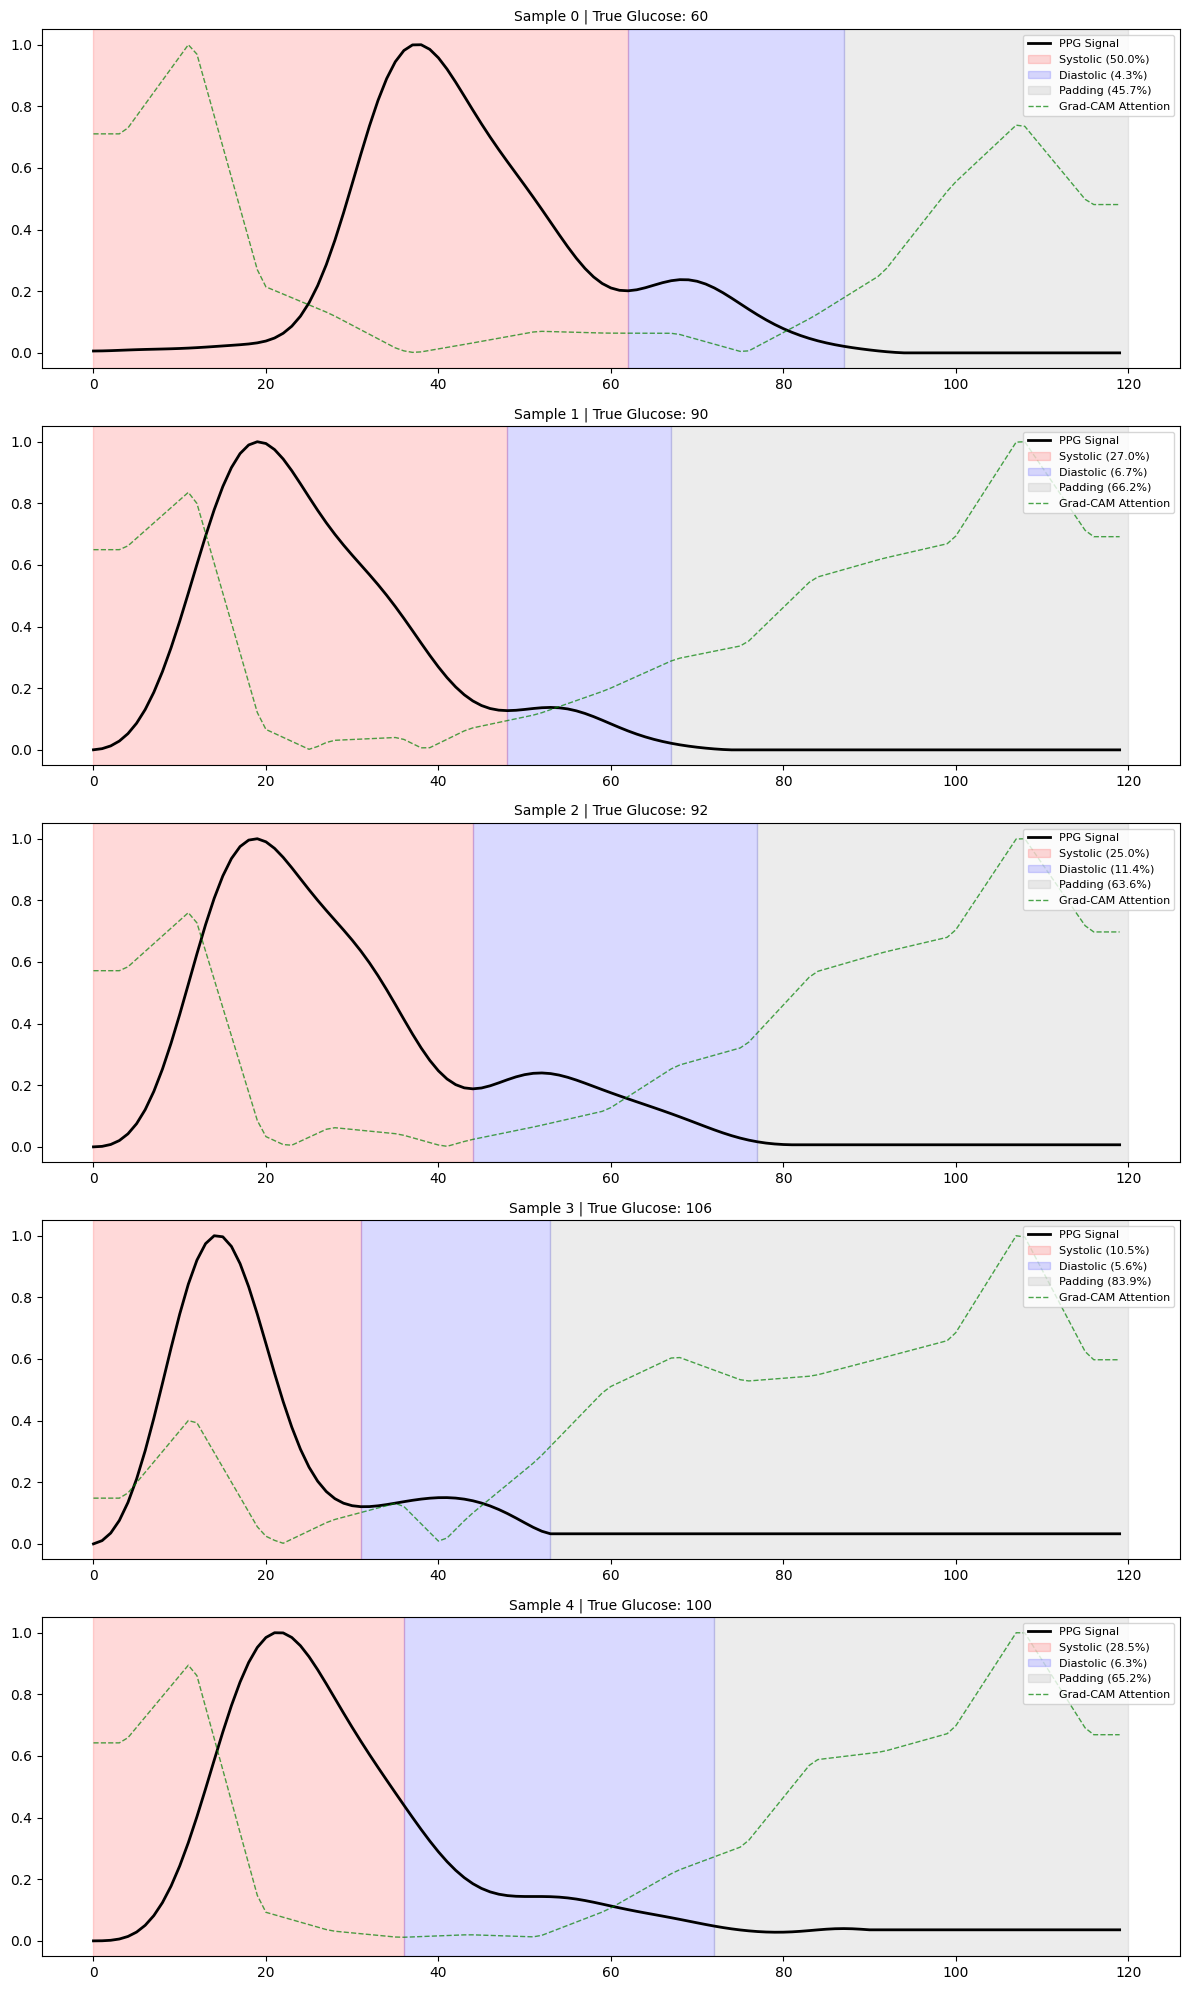


ZONE                 | AVG IMPORTANCE %   | TARGET STATUS
1. Systolic (Peak)   | 35.8%             | Expected High
2. Diastolic (Tail)  | 10.4%             | CRITICAL (Stiffness)
3. Padding (Flat)    | 53.8%             | MUST BE LOW (< 10%)


In [ ]:
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

def quantifty_feature_importance(model, test_loader, device, num_plots=5):
    print(f"\n--- Quantifying Feature Importance (Visualizing {num_plots} samples) ---")

    # Initialize GradCAM
    target_layer = model.block5[-1].conv2
    grad_cam = GradCAM1D_Raw(model, target_layer)

    # Store aggregated stats
    stats = {
        'systolic_imp': [],
        'diastolic_imp': [],
        'padding_imp': []
    }

    model.eval()

    # Get one batch
    inputs, targets = next(iter(test_loader))
    inputs = inputs.to(device)

    # Create a figure for the plots
    fig, axes = plt.subplots(num_plots, 1, figsize=(12, 4 * num_plots))
    if num_plots == 1: axes = [axes]
    plt.subplots_adjust(hspace=0.4)

    for i in range(len(inputs)):
        # 1. Get Signal and Heatmap
        input_tensor = inputs[i].unsqueeze(0)
        input_tensor.requires_grad = True

        # Get raw heatmap
        heatmap, _ = grad_cam(input_tensor)

        # Upsample heatmap to 120
        heatmap = F.interpolate(
            heatmap.view(1, 1, -1), size=120, mode='linear', align_corners=False
        ).squeeze().detach().numpy()

        # Use Absolute Magnitude for Importance (Negative gradients are also "attention")
        importance_map = np.abs(heatmap)

        # 2. Segment the Signal (Logic to find zones)
        signal = input_tensor.squeeze().detach().cpu().numpy()

        # A. Find Padding Start (Flat tail)
        # Look backwards. Stop when derivative > threshold
        diff = np.abs(np.diff(signal))
        pad_start = 120
        for j in range(118, 0, -1):
            if diff[j] > 0.005:
                pad_start = j + 1
                break

        # B. Find Systolic Peak (Max of non-padded area)
        if pad_start > 5:
            sys_peak_idx = np.argmax(signal[:pad_start])
        else:
            sys_peak_idx = 10

        # C. Find Dicrotic Notch (Split between Sys and Dia)
        # Try to find valley after peak
        split_idx = sys_peak_idx + 15 # Default fallback
        search_area = signal[sys_peak_idx:pad_start]
        if len(search_area) > 5:
            valleys = scipy.signal.argrelextrema(search_area, np.less)[0]
            if len(valleys) > 0:
                split_idx = sys_peak_idx + valleys[0]

        split_idx = min(split_idx, pad_start - 1)

        # 3. Sum Importance in Zones
        score_sys = np.sum(importance_map[0:split_idx])
        score_dia = np.sum(importance_map[split_idx:pad_start])
        score_pad = np.sum(importance_map[pad_start:])

        total_score = score_sys + score_dia + score_pad + 1e-8

        pct_sys = score_sys / total_score * 100
        pct_dia = score_dia / total_score * 100
        pct_pad = score_pad / total_score * 100

        stats['systolic_imp'].append(pct_sys)
        stats['diastolic_imp'].append(pct_dia)
        stats['padding_imp'].append(pct_pad)

        # 4. Plot if within limit
        if i < num_plots:
            ax = axes[i]
            # Plot Signal
            ax.plot(signal, 'k-', linewidth=2, label='PPG Signal')

            # Color Zones
            ax.axvspan(0, split_idx, color='red', alpha=0.15, label=f'Systolic ({pct_sys:.1f}%)')
            ax.axvspan(split_idx, pad_start, color='blue', alpha=0.15, label=f'Diastolic ({pct_dia:.1f}%)')
            ax.axvspan(pad_start, 120, color='gray', alpha=0.15, label=f'Padding ({pct_pad:.1f}%)')

            # Plot Importance Overlay (Scaled to fit plot)
            # Normalize importance to match signal height for visualization
            imp_norm = importance_map / importance_map.max() * (signal.max() - signal.min()) + signal.min()
            ax.plot(imp_norm, 'g--', linewidth=1, alpha=0.7, label='Grad-CAM Attention')

            ax.set_title(f"Sample {i} | True Glucose: {targets[i].item():.0f}", fontsize=10)
            ax.legend(loc='upper right', fontsize=8)

    plt.tight_layout()
    plt.show()

    # 5. Print Global Stats
    print("\n" + "="*60)
    print(f"{'ZONE':<20} | {'AVG IMPORTANCE %':<18} | {'TARGET STATUS'}")
    print("="*60)
    print(f"{'1. Systolic (Peak)':<20} | {np.mean(stats['systolic_imp']):.1f}%             | Expected High")
    print(f"{'2. Diastolic (Tail)':<20} | {np.mean(stats['diastolic_imp']):.1f}%             | CRITICAL (Stiffness)")
    print(f"{'3. Padding (Flat)':<20} | {np.mean(stats['padding_imp']):.1f}%             | MUST BE LOW (< 10%)")

# Run it
if 'model' in globals():
    quantifty_feature_importance(model, test_loader_v2, device, num_plots=5)